In [1]:
import sparkmonitor
!jupyter nbextension install sparkmonitor --py --user --symlink 
!jupyter nbextension enable sparkmonitor --py --user            
!jupyter serverextension enable --py --user sparkmonitor
!ipython profile create && echo "c.InteractiveShellApp.extensions.append('sparkmonitor.kernelextension')" >>  $(ipython profile locate default)/ipython_kernel_config.py

Installing /usr/local/lib/python3.7/site-packages/sparkmonitor/static -> sparkmonitor
- Validating: OK

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable sparkmonitor --user --py
    
Enabling notebook extension sparkmonitor/module...
      - Validating: OK
Enabling: sparkmonitor.serverextension
- Writing config: /Users/echuraev/.jupyter
    - Validating...
      sparkmonitor.serverextension  OK


In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

conf.setAppName('DMF')
conf.setMaster('local[*]')
print(conf.toDebugString())

sc = SparkContext.getOrCreate(conf=conf)
spark = SparkSession(sc)

spark.extraListeners=sparkmonitor.listener.JupyterSparkMonitorListener
spark.driver.extraClassPath=/usr/local/lib/python3.7/site-packages/sparkmonitor/listener.jar
spark.app.name=DMF
spark.master=local[*]


In [5]:
df1=spark.read.csv('/Users/echuraev/Workspace/Nastya/DMF/DMF/ssdm1')
df2=spark.read.csv('/Users/echuraev/Workspace/Nastya/DMF/DMF/ssdm2')
df3=spark.read.csv('/Users/echuraev/Workspace/Nastya/DMF/DMF/ssdm3')
df=df1.union(df2).union(df3)

In [6]:
df.show(10)

+--------------------+
|                 _c0|
+--------------------+
| 001010001MUZZEY ...|
| 001010009SMITH  ...|
| 001010010HAMMOND...|
| 001010011DREW   ...|
| 001010012CATE   ...|
| 001010013WHORFE ...|
| 001010015AMOS   ...|
| 001010016KUNCHO ...|
| 001010017MICHALS...|
| 001010019BODWELL...|
+--------------------+
only showing top 10 rows



In [7]:
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.functions import udf, to_date
import re

udf1 = udf(lambda x:x[0:1].strip(),StringType())
udf2 = udf(lambda x:x[1:10].strip(),StringType())
udf3 = udf(lambda x:x[10:30].strip(),StringType())
udf4 = udf(lambda x:x[30:34].strip(),StringType())
udf5 = udf(lambda x:x[34:49].strip(),StringType())
udf6 = udf(lambda x:x[49:64].strip(),StringType())
udf7 = udf(lambda x:x[64:65].strip(),StringType())
udf8 = udf(lambda x:re.sub("00(\d{4})",r'01\1',x[65:73].strip()),StringType())
udf9 = udf(lambda x:x[73:81].strip(),StringType())

df=df.withColumn('transaction_type',udf1('_c0'))\
    .withColumn('security_number',udf2('_c0'))\
    .withColumn('last_name',udf3('_c0'))\
    .withColumn('name_suffix',udf4('_c0'))\
    .withColumn('first_name',udf5('_c0'))\
    .withColumn('middle_name',udf6('_c0'))\
    .withColumn('V/P',udf7('_c0'))\
    .withColumn('death_date',to_date(udf8('_c0'),'MMddyyyy'))\
    .withColumn('birth_date',to_date(udf9('_c0'),'MMddyyyy'))\
    .drop('_c0')

In [8]:
df.limit(20).toPandas()

,transaction_type,security_number,last_name,name_suffix,first_name,middle_name,V/P,death_date,birth_date
0,,001010001,MUZZEY,,GRACE,,,1975-12-01,1902-04-16
1,,001010009,SMITH,,ROGER,,,1969-04-01,1892-02-04
2,,001010010,HAMMOND,,KENNETH,,,1976-03-01,1904-04-24
3,,001010011,DREW,,LEON,R,V,1987-08-30,1908-06-14
4,,001010012,CATE,,OLIVE,,,1981-09-01,1908-09-21
5,,001010013,WHORFE,,FRANK,,,1962-09-01,1888-04-06
6,,001010015,AMOS,,CHESTER,,,1984-02-01,1910-02-16
7,,001010016,KUNCHO,,DIMITRI,,,1981-03-01,1910-06-04
8,,001010017,MICHALS,,WILLIAM,,,1970-12-01,1907-11-07
9,,001010019,BODWELL,,MINNIE,,,1984-03-01,1895-04-05


In [9]:
df=df.drop('transaction_type').withColumnRenamed("V/P","VP")

In [10]:
df=df.dropna()

In [11]:
from pyspark.sql.functions import month, dayofmonth, udf, col,year
zodiacs = [('120', 'Capricorn'), ('218', 'Aquarius'), ('320', 'Pisces'), ('420', 'Aries'), ('521', 'Taurus'),
           ('621', 'Gemini'), ('722', 'Cancer'), ('823', 'Leo'), ('923', 'Virgo'), ('1023', 'Libra'),
           ('1122', 'Scorpio'), ('1222', 'Sagittarius'), ('1231', 'Capricorn')]
def get_zodiac_of_date(month_, day_):
    if len(str(day_)) ==1:
        data = str(month_)+ '0' +str(day_)
    else:
        data = str(month_) + str(day_)
    for z in zodiacs:
        if int(data) <= int(z[0]):
            return z[1]

In [12]:
zodiacs_numb = [('120', 0), ('218', 1), ('320', 2), ('420', 3), ('521', 4),
                ('621', 5), ('722', 6), ('823', 7), ('923', 8), ('1023', 9),
                ('1122', 10), ('1222', 11), ('1231', 0)]
def get_zodiac_numb(month_, day_):
    if len(str(day_)) ==1:
        data = str(month_)+ '0' +str(day_)
    else:
        data = str(month_) + str(day_)
    for z in zodiacs_numb:
        if int(data) <= int(z[0]):
            return z[1]

In [13]:
My_UDF = udf(get_zodiac_of_date, StringType())
My_UDF_1 = udf(get_zodiac_numb, IntegerType())
df = df.withColumn('zodiac_sign', My_UDF((month('birth_date')), dayofmonth('birth_date')))
df = df.withColumn('zodiac_sign_number', My_UDF_1((month('birth_date')), dayofmonth('birth_date')))
df = df.withColumn('age', year(df.death_date)-year(df.birth_date))
df.limit(10).toPandas()

,security_number,last_name,name_suffix,first_name,middle_name,VP,death_date,birth_date,zodiac_sign,zodiac_sign_number,age
0,001010001,MUZZEY,,GRACE,,,1975-12-01,1902-04-16,Aries,3,73
1,001010009,SMITH,,ROGER,,,1969-04-01,1892-02-04,Aquarius,1,77
2,001010010,HAMMOND,,KENNETH,,,1976-03-01,1904-04-24,Taurus,4,72
3,001010011,DREW,,LEON,R,V,1987-08-30,1908-06-14,Gemini,5,79
4,001010012,CATE,,OLIVE,,,1981-09-01,1908-09-21,Virgo,8,73
5,001010013,WHORFE,,FRANK,,,1962-09-01,1888-04-06,Aries,3,74
6,001010015,AMOS,,CHESTER,,,1984-02-01,1910-02-16,Aquarius,1,74
7,001010016,KUNCHO,,DIMITRI,,,1981-03-01,1910-06-04,Gemini,5,71
8,001010017,MICHALS,,WILLIAM,,,1970-12-01,1907-11-07,Scorpio,10,63
9,001010019,BODWELL,,MINNIE,,,1984-03-01,1895-04-05,Aries,3,89


In [14]:
zod=df.select(df.zodiac_sign).distinct().count()

In [15]:
print(zod)

12


In [16]:
zod=df.select(df.zodiac_sign).distinct().show()

+-----------+
|zodiac_sign|
+-----------+
|      Virgo|
|     Pisces|
|     Taurus|
|      Aries|
|      Libra|
|Sagittarius|
|     Cancer|
|  Capricorn|
|     Gemini|
|   Aquarius|
|        Leo|
|    Scorpio|
+-----------+



In [17]:
df.summary().show()

+-------+--------------------+---------+-----------+--------------------+------------------+--------+-----------+------------------+------------------+
|summary|     security_number|last_name|name_suffix|          first_name|       middle_name|      VP|zodiac_sign|zodiac_sign_number|               age|
+-------+--------------------+---------+-----------+--------------------+------------------+--------+-----------+------------------+------------------+
|  count|            87556428| 87556428|   87556428|            87556428|          87556428|87556428|   87556428|          87556428|          87556428|
|   mean|3.2455755800756687E8|     null|       null| 2.765166666666667E8| 1.915335463258786|    null|       null| 5.492667048957274| 72.94544800297244|
| stddev| 1.675576033523022E8|     null|       null|2.9333901984094167E8|1.8540821037063988|    null|       null| 3.410201111297366|16.123097009896345|
|    min|           001010001|   #ETERS|           |                    |               

In [18]:
df.createOrReplaceTempView("DMF")
spark.sql("SELECT count(*) as out,zodiac_sign\
    FROM DMF\
    GROUP BY zodiac_sign").show()

+-------+-----------+
|    out|zodiac_sign|
+-------+-----------+
|7831939|      Virgo|
|7608692|     Pisces|
|7173084|     Taurus|
|7435399|      Aries|
|7324794|      Libra|
|6850005|Sagittarius|
|7373056|     Cancer|
|7036576|  Capricorn|
|7086109|     Gemini|
|7063765|   Aquarius|
|7896353|        Leo|
|6876656|    Scorpio|
+-------+-----------+



In [19]:
df.groupBy(df.zodiac_sign)\
    .count()\
    .toPandas()\
    .plot.bar(x='zodiac_sign',y='count',figsize=(15,10),fontsize=40)

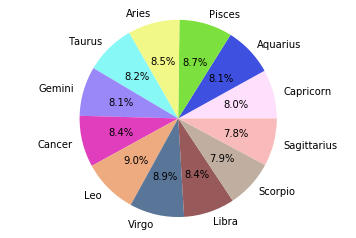

In [20]:
label_zodiac='Capricorn','Aquarius','Pisces','Aries','Taurus','Gemini','Cancer','Leo','Virgo','Libra','Scorpio','Sagittarius'
colors = ['#FFE0FC','#3E50E0','#7CE03E','#F2F887','#87F8F6','#9A87F8','#E03EBC','#EFAB80','#597597','#97595A','#C0AFA0','#F8BABA']
import matplotlib.pyplot as plt
fig1, ax1 = plt.subplots()
sizes=df.groupBy(df.zodiac_sign_number)\
    .count()\
    .orderBy('zodiac_sign_number')\
    .toPandas()['count']
ax1.pie(sizes[0:], autopct='%1.1f%%', labels = label_zodiac, colors = colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [21]:
def build_graphic(zod,title):
    spark.sql("SELECT age,\
        count(*) as count\
        FROM DMF\
        WHERE zodiac_sign_number = " + str(zod) + "\
        GROUP BY age\
        ORDER BY age")\
        .toPandas()\
        .plot(x='age',y='count',title = str(title))
    plt.xlim(0, 90)
    plt.xlabel('age of death', fontsize=10)
    plt.ylabel('count', fontsize=10)

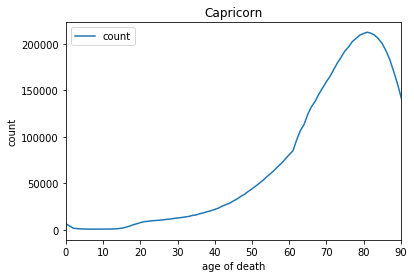

In [22]:
build_graphic(0, label_zodiac[0])

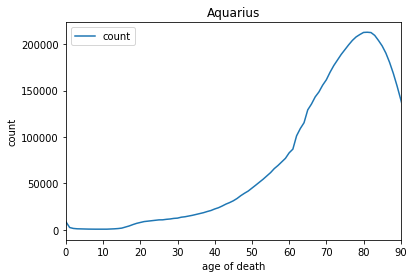

In [23]:
build_graphic(1, label_zodiac[1])

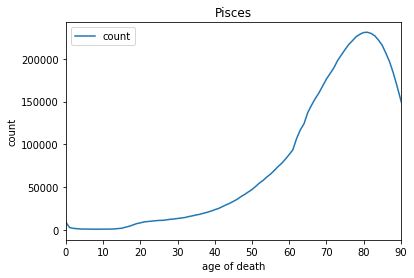

In [24]:
build_graphic(2, label_zodiac[2])

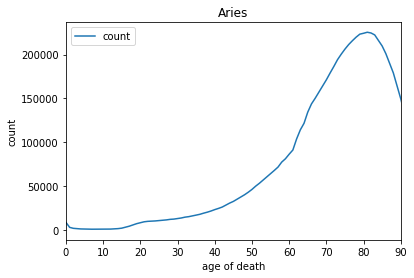

In [25]:
build_graphic(3, label_zodiac[3])

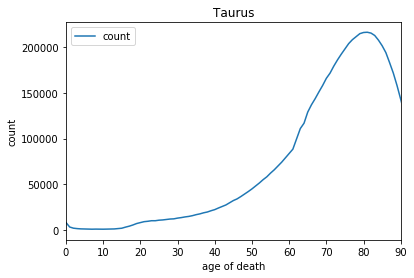

In [35]:
build_graphic(4, label_zodiac[4])

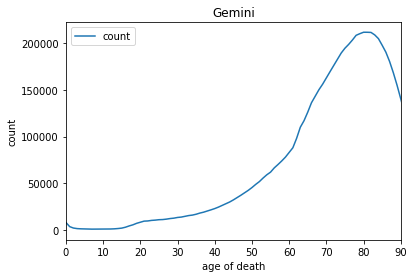

In [27]:
build_graphic(5, label_zodiac[5])

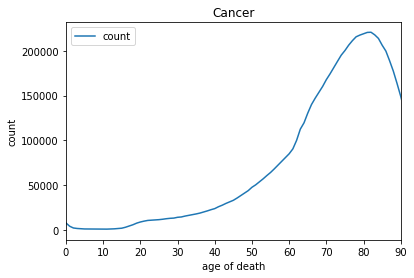

In [28]:
build_graphic(6, label_zodiac[6])

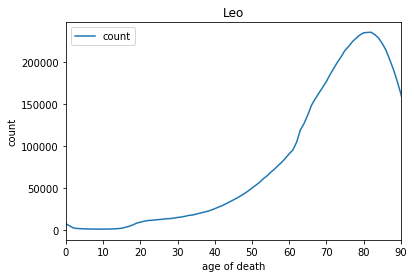

In [29]:
build_graphic(7, label_zodiac[7])

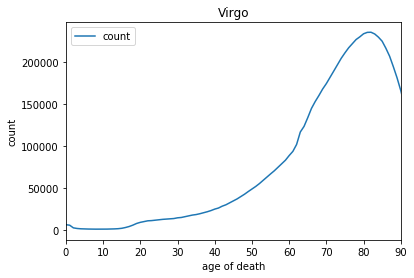

In [30]:
build_graphic(8, label_zodiac[8])

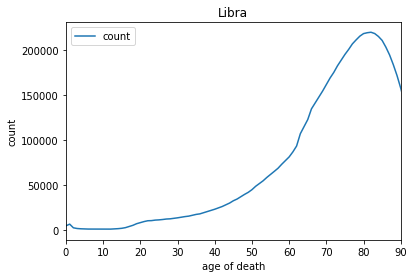

In [31]:
build_graphic(9, label_zodiac[9])

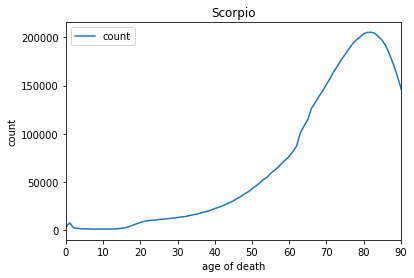

In [32]:
build_graphic(10, label_zodiac[10])

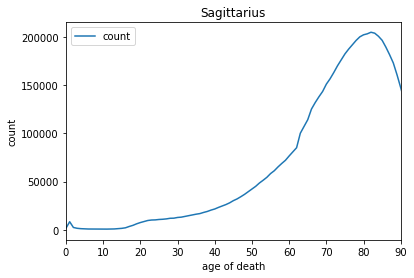

In [33]:
build_graphic(11, label_zodiac[11])

In [34]:
spark.sql("SELECT avg(age) as age,zodiac_sign\
    FROM DMF\
    GROUP BY zodiac_sign").show()

+-----------------+-----------+
|              age|zodiac_sign|
+-----------------+-----------+
|73.14848787765074|      Virgo|
| 72.8810535371914|     Pisces|
|72.78747579144479|     Taurus|
|72.85905557993593|      Aries|
|73.28324509877001|      Libra|
| 73.2762859297183|Sagittarius|
|72.71751048683205|     Cancer|
|72.97434547711842|  Capricorn|
|72.62841751375825|     Gemini|
|72.68701337034854|   Aquarius|
|72.87803128862147|        Leo|
|73.23866803865134|    Scorpio|
+-----------------+-----------+

